In [1]:
import spacy
nlp = spacy.blank('id')
import gensim
import pandas as pd
import nltk
import numpy as np
from sklearn import preprocessing

In [2]:
df = pd.read_excel("dataset_twitter.xlsx")
df.head()

,label,komentar
0,positif,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
1,positif,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
2,positif,Sharing sama temen tuh emg guna bgt. Disaat lu...
3,positif,"sangat bersyukur bisa mendoakan kakeknya, Bung..."
4,positif,H-9. Mau ke bank rame bgt ampe antrian tempat ...


In [3]:
import re
import string
nltk.download('punkt')

komentar = df['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,label,komentar
0,positif,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
1,positif,"[sharing, pengalaman, aja, kemarin, jam, batal..."
2,positif,"[sharing, sama, temen, tuh, emg, guna, bgt, di..."
3,positif,"[sangat, bersyukur, bisa, mendoakan, kakeknya,..."
4,positif,"[h, mau, ke, bank, rame, bgt, ampe, antrian, t..."
...,...,...
3110,netral,"[bukan, saya, yang, tidakmau, merit, sat, ini,..."
3111,netral,"[baru, lihat, kabar, teman, nge, gosip, dan, p..."
3112,netral,"[mengubah, kebiasaan, seseorang, yg, kurang, b..."
3113,netral,"[nah, diam, lebih, bagus, yaudah, saya, diam, ..."


In [4]:
df = df[df.komentar.astype(bool)]

X_temp = df['komentar']
y = df['label']

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
from gensim.models.fasttext import FastText
model = FastText.load('Model/XGB.bin')

In [7]:
from MeanVectorizer import MeanEmbeddingVectorizer
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [8]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [9]:
import xgboost as xgb
from xgboost import XGBClassifier

In [10]:
lc=preprocessing.LabelEncoder()
lc.fit(y)

LabelEncoder()

In [11]:
y_train_enc=lc.transform(y_train)
y_test_enc=lc.transform(y_test)

In [12]:
weights = y_train_enc
weights = np.choose(weights, [0.9, 1, 0.95])

train=xgb.DMatrix(X_train_vector,label=y_train_enc, weight=weights)
test=xgb.DMatrix(X_test_vector,label=y_test_enc)

print("\nIni Weights\n", weights, "\n")
print("Ini y_train_encode\n", y_train_enc, "\n")


Ini Weights
 [0.9  0.9  1.   ... 1.   0.95 0.95] 

Ini y_train_encode
 [0 0 1 ... 1 2 2] 



In [13]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.3
# Max Depth:  7
# Subsample:  0.4
# Colsample Bytree:  0.6
# Alpha:  0
# Lamda:  1.5
# Min Child Weight:  1
# Number of Trees:  1000
    
param['num_class']=len(set(y))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.3
param['max_depth'] = 7
param['subsample'] = 0.4
param['colsample_bytree'] = 0.6
param['reg_alpha'] = 0
param['reg_lambda'] = 1.5
param['min_child_weight'] = 1
num_round = 1000

# param['num_class']=len(set(y))
# param['learning_rate'] = 0.001
# param['max_depth'] = 7
# param['min_child_weight'] = 10
# param['gamma'] = 2
# param['reg_alpha'] = 0.9
# param['reg_lambda'] = 4
# param['subsample'] = 0.7
# param['colsample_bytree'] = 1
# param['objective'] = 'multi:softmax'
# param['scale_pos_weight'] = 1

watchlist = [(train, 'train'), (test, 'test')]
# num_round = 100
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.38930	test-merror:0.55698
[1]	train-merror:0.29608	test-merror:0.52648
[2]	train-merror:0.24750	test-merror:0.52648
[3]	train-merror:0.22884	test-merror:0.49438
[4]	train-merror:0.20125	test-merror:0.50241
[5]	train-merror:0.17931	test-merror:0.48957
[6]	train-merror:0.16683	test-merror:0.47191
[7]	train-merror:0.14430	test-merror:0.45907
[8]	train-merror:0.13251	test-merror:0.47673
[9]	train-merror:0.12077	test-merror:0.46709
[10]	train-merror:0.11279	test-merror:0.47191
[11]	train-merror:0.10532	test-merror:0.47512
[12]	train-merror:0.09756	test-merror:0.47030
[13]	train-merror:0.09707	test-merror:0.47833
[14]	train-merror:0.09189	test-merror:0.47994
[15]	train-merror:0.09356	test-merror:0.47512
[16]	train-merror:0.08816	test-merror:0.47191
[17]	train-merror:0.08778	test-merror:0.47352
[18]	train-merror:0.08421	test-merror:0.46067
[19]	train-merror:0.08355	test-merror:0.45586
[20]	train-merror:0.07995	test-merror:0.45265
[21]	train-merror:0.07877	test-merror:0.4462

[177]	train-merror:0.01348	test-merror:0.41091
[178]	train-merror:0.01263	test-merror:0.40931
[179]	train-merror:0.01346	test-merror:0.41091
[180]	train-merror:0.01346	test-merror:0.41413
[181]	train-merror:0.01346	test-merror:0.41252
[182]	train-merror:0.01346	test-merror:0.40931
[183]	train-merror:0.01305	test-merror:0.41252
[184]	train-merror:0.01305	test-merror:0.41252
[185]	train-merror:0.01346	test-merror:0.41413
[186]	train-merror:0.01346	test-merror:0.41573
[187]	train-merror:0.01303	test-merror:0.41252
[188]	train-merror:0.01303	test-merror:0.41091
[189]	train-merror:0.01346	test-merror:0.41252
[190]	train-merror:0.01346	test-merror:0.40931
[191]	train-merror:0.01346	test-merror:0.41091
[192]	train-merror:0.01346	test-merror:0.41091
[193]	train-merror:0.01346	test-merror:0.41413
[194]	train-merror:0.01308	test-merror:0.41413
[195]	train-merror:0.01303	test-merror:0.41573
[196]	train-merror:0.01346	test-merror:0.41252
[197]	train-merror:0.01350	test-merror:0.40770
[198]	train-m

[352]	train-merror:0.00406	test-merror:0.39647
[353]	train-merror:0.00366	test-merror:0.39647
[354]	train-merror:0.00368	test-merror:0.39647
[355]	train-merror:0.00368	test-merror:0.39647
[356]	train-merror:0.00328	test-merror:0.39647
[357]	train-merror:0.00370	test-merror:0.39807
[358]	train-merror:0.00411	test-merror:0.39807
[359]	train-merror:0.00368	test-merror:0.39807
[360]	train-merror:0.00368	test-merror:0.39807
[361]	train-merror:0.00368	test-merror:0.39647
[362]	train-merror:0.00290	test-merror:0.39647
[363]	train-merror:0.00290	test-merror:0.39647
[364]	train-merror:0.00290	test-merror:0.39486
[365]	train-merror:0.00290	test-merror:0.39326
[366]	train-merror:0.00290	test-merror:0.39486
[367]	train-merror:0.00290	test-merror:0.39486
[368]	train-merror:0.00328	test-merror:0.39807
[369]	train-merror:0.00328	test-merror:0.39647
[370]	train-merror:0.00328	test-merror:0.39807
[371]	train-merror:0.00286	test-merror:0.39807
[372]	train-merror:0.00286	test-merror:0.39647
[373]	train-m

[527]	train-merror:0.00082	test-merror:0.39486
[528]	train-merror:0.00082	test-merror:0.39486
[529]	train-merror:0.00082	test-merror:0.39486
[530]	train-merror:0.00082	test-merror:0.39165
[531]	train-merror:0.00082	test-merror:0.39486
[532]	train-merror:0.00082	test-merror:0.39486
[533]	train-merror:0.00082	test-merror:0.39486
[534]	train-merror:0.00082	test-merror:0.39647
[535]	train-merror:0.00082	test-merror:0.39647
[536]	train-merror:0.00082	test-merror:0.39647
[537]	train-merror:0.00082	test-merror:0.39647
[538]	train-merror:0.00082	test-merror:0.39647
[539]	train-merror:0.00040	test-merror:0.39647
[540]	train-merror:0.00040	test-merror:0.39486
[541]	train-merror:0.00040	test-merror:0.39647
[542]	train-merror:0.00040	test-merror:0.39807
[543]	train-merror:0.00040	test-merror:0.39807
[544]	train-merror:0.00040	test-merror:0.39807
[545]	train-merror:0.00040	test-merror:0.39647
[546]	train-merror:0.00040	test-merror:0.39807
[547]	train-merror:0.00040	test-merror:0.39968
[548]	train-m

[702]	train-merror:0.00040	test-merror:0.38844
[703]	train-merror:0.00040	test-merror:0.38844
[704]	train-merror:0.00040	test-merror:0.38844
[705]	train-merror:0.00040	test-merror:0.38844
[706]	train-merror:0.00040	test-merror:0.38844
[707]	train-merror:0.00040	test-merror:0.38844
[708]	train-merror:0.00040	test-merror:0.38844
[709]	train-merror:0.00040	test-merror:0.38844
[710]	train-merror:0.00040	test-merror:0.38844
[711]	train-merror:0.00040	test-merror:0.38844
[712]	train-merror:0.00040	test-merror:0.38844
[713]	train-merror:0.00040	test-merror:0.38844
[714]	train-merror:0.00040	test-merror:0.38844
[715]	train-merror:0.00040	test-merror:0.38844
[716]	train-merror:0.00040	test-merror:0.38844
[717]	train-merror:0.00040	test-merror:0.38844
[718]	train-merror:0.00040	test-merror:0.38684
[719]	train-merror:0.00040	test-merror:0.38684
[720]	train-merror:0.00040	test-merror:0.39005
[721]	train-merror:0.00040	test-merror:0.38844
[722]	train-merror:0.00040	test-merror:0.38844
[723]	train-m

[877]	train-merror:0.00000	test-merror:0.38684
[878]	train-merror:0.00000	test-merror:0.38523
[879]	train-merror:0.00000	test-merror:0.38523
[880]	train-merror:0.00000	test-merror:0.38523
[881]	train-merror:0.00000	test-merror:0.38523
[882]	train-merror:0.00000	test-merror:0.38684
[883]	train-merror:0.00000	test-merror:0.38523
[884]	train-merror:0.00000	test-merror:0.38363
[885]	train-merror:0.00000	test-merror:0.38523
[886]	train-merror:0.00000	test-merror:0.38523
[887]	train-merror:0.00000	test-merror:0.38523
[888]	train-merror:0.00000	test-merror:0.38523
[889]	train-merror:0.00000	test-merror:0.38523
[890]	train-merror:0.00000	test-merror:0.38523
[891]	train-merror:0.00000	test-merror:0.38523
[892]	train-merror:0.00000	test-merror:0.38523
[893]	train-merror:0.00000	test-merror:0.38523
[894]	train-merror:0.00000	test-merror:0.38523
[895]	train-merror:0.00000	test-merror:0.38523
[896]	train-merror:0.00000	test-merror:0.38523
[897]	train-merror:0.00000	test-merror:0.38523
[898]	train-m

In [14]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [15]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.6179775280898876 

Train Score
 1.0 

CONFUSSION MATRIX
 [[164  35  21]
 [ 50 109  41]
 [ 37  54 112]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.65      0.75      0.70       220
      netral       0.55      0.55      0.55       200
     positif       0.64      0.55      0.59       203

    accuracy                           0.62       623
   macro avg       0.62      0.61      0.61       623
weighted avg       0.62      0.62      0.62       623
 



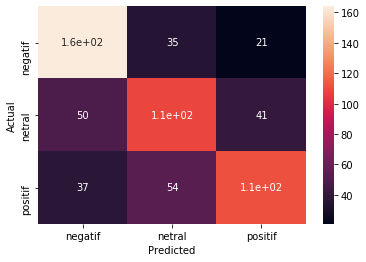

In [17]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [18]:
# # Create XGB Classifier object
# xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# # Create parameter grid
# # parameters = {"learning_rate": [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001],
# #                "gamma" : [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1, 1.5, 2, 3, 4, 6],
# #                "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
# #                "colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
# #                "subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
# #                "reg_alpha": [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
# #                "reg_lambda": [1, 1.5, 2, 3, 4.5, 4, 5],
# #                "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
# #                "n_estimators": [100, 250, 500, 1000],
# #                "num_boost_round": [100, 250, 500, 750, 1000]}

# parameters = {"learning_rate": [0.1, 0.01, 0.001],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 10, verbose = 3, random_state = 40 )
           
# # Fit the model
# model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# # Model best estimators
# print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
# print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
# print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
# print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
# print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
# print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
# print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
# print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
# print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])